## Problem statement: <br>
We need to create a model that can accurately predict future stock market prices using machine learning and previous stock market datasets.

**Dataset description:** <br>
In order to model the stock market, we have chosen a dataset from Kaggle with 8,500 files, each containing dense information from all US-based stocks, including ETFs trading on the New York Stock Exchange (NYSE), NASDAQ, and the NYSE MKT: 
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs. <br>
It is difficult but crucial to acquire high-quality data since the results of the model will be largely dependent on the accuracy and validity of the data. Incomplete datasets where there are missing data values for certain values can cause inconsistencies and introduce biases in the model if we have to remove entire instances or give default values to certain attributes. For these reasons, we made sure to find a high-quality financial data set that contains full historical daily price and volume data, last updated on November 10, 2017 by Boris Marjanovic. The dataset includes the following attributes: Date, Open, High, Low, Close, Volume, OpenInt for each stock, where each CSV file contains hundreds of rows – each corresponding to an instance in our dataset which is a single stock. Open represents the opening price, High and Low represent the corresponding maximum and minimum price during the day, Close represents the close price as adjusted for splits, Volume measures the number of shares that exchanges hands throughout the day, and OpenInt to represent Open Interest. Prices have been adjusted to account for dividends and splits.

**Goals:** <br>
Our goal is to build an accurate model that can predict the prices of certain US stocks based on various variables. With high-quality data that will undergo thorough data cleaning through a data processing stage, we want to predict the ups and downs of the stock market and create a well documented model and frontend that is both intuitive and easy for users and developers.

**Timeline:** <br>
Data cleaning/visualization 4/20 <br>
Initial machine learning, training model 4/25 <br>
Improve our model, testing for overfitting/underfitting (QA)  5/1 <br>
Build frontend for model 5/6 <br>
Write documentation for model 5/10 <br>
Test frontend 5/15 <br>
Presentations start 5/31 <br>

The timeline is subject to change based on our availability throughout the quarter. 


In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

## Data Cleaning

In [2]:
path = 'us_etf_stocks_dataset\\'
#path = 'E:\\Dataset\\'

# read in major ETFs 
voo = pd.read_csv(path + 'ETFs\\voo.us.txt')
vt = pd.read_csv(path + 'ETFs\\vt.us.txt')
vti = pd.read_csv(path + 'ETFs\\vti.us.txt')
spy = pd.read_csv(path + 'ETFs\\spy.us.txt')
qqq = pd.read_csv(path + 'ETFs\\qqq.us.txt')

nvda = pd.read_csv(path + 'Stocks\\nvda.us.txt')

# checking 'OpenInt' value 
print(nvda[nvda['OpenInt'] != 0].head())
print(voo[voo['OpenInt'] != 0].head())
print(spy[spy['OpenInt'] != 0].head())

print(spy.head())
print(qqq.head())
print(vti.head())

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
         Date    Open    High     Low   Close    Volume  OpenInt
0  2005-02-25  104.77  106.00  104.68  105.79  70221808        0
1  2005-02-28  105.55  105.68  104.56  105.08  79695344        0
2  2005-03-01  105.22  105.87  105.22  105.62  54607412        0
3  2005-03-02  105.21  106.22  105.10  105.57  73733090        0
4  2005-03-03  105.99  106.20  105.15  105.61  71286823        0
         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-03-10  45.722  45.750  44.967  45.665  11700414        0
1  1999-03-11  45.994  46.260  44.988  45.880  21670048        0
2  1999-03-12  45.721  45.749  44.406  44.770  19553768        0
3  1999-03-15  45.101  46.103  44.625  46.052  14245348        0
4  1999-03-16  46.253  46.643  45.74

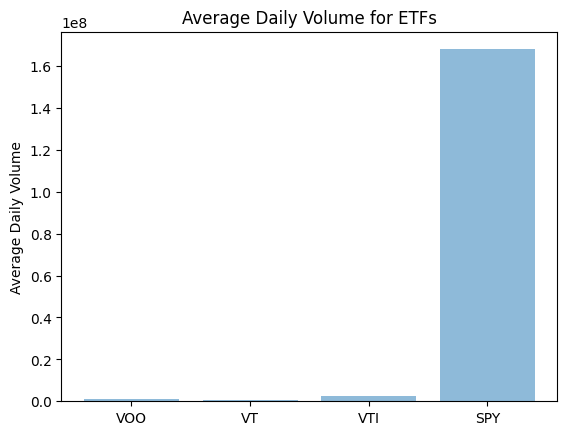

In [3]:
# visualize the daily volume for major ETFs
etfs = ['VOO', 'VT', 'VTI', 'SPY']
avg_volumes = [voo['Volume'].mean(), vt['Volume'].mean(), vti['Volume'].mean(), spy['Volume'].mean()]

y_pos = np.arange(len(etfs))

plt.bar(y_pos, avg_volumes, align='center', alpha=0.5)
plt.xticks(y_pos, etfs)
plt.ylabel('Average Daily Volume')
plt.title('Average Daily Volume for ETFs')

plt.show()

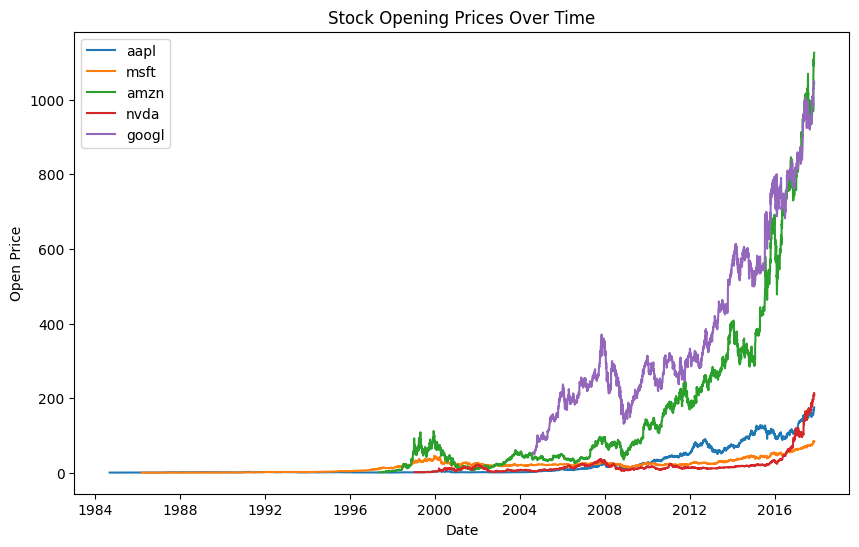

In [4]:
# top 50 companies in SPY (by weight)
spy_companies = ['aapl', 'msft', 'amzn', 'nvda', 'googl', #'brk-b', 'goog', 'fb', 'xom', 'unh', 'tsla', 'jnj', 'jpm', 'v', 
                #'pg', 'ma', 'lly', 'hd', 'cvx', 'mrk', 'abbv', 'pep', 'avgo', 'ko', 'cost', 'pfe', 'crm', 'mcd', 'wmt', 
                #'tmo', 'csco', 'bac', 'amd', 'acn','adbe', 'abt', 'cmcsa', 'dis', 'orcl', 'nflx', 'wfc', 'txn', 'dhr',
                #'vz', 'nee', 'pm', 'bmy', 'nke'
                ]

# generalized function to find the dataset for a specific set of stocks
def read_stock_data(stock_names):
    stock_data = {}
    for stock in stock_names:
        stock_data[stock] = pd.read_csv(path + f'Stocks\\{stock}.us.txt')
        # convert 'date' column to datatime objects
        stock_data[stock]['Date'] = pd.to_datetime(stock_data[stock]['Date'])
    return stock_data

# initalize data for spy_companies 
stock_data = read_stock_data(spy_companies)

# visualize the opening prices over time for spy companies 
fig = plt.figure(figsize=(10, 6))

for stock_name, data in stock_data.items():
    plt.plot(data['Date'], data['Open'], label=stock_name)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Opening Prices Over Time')
plt.show()

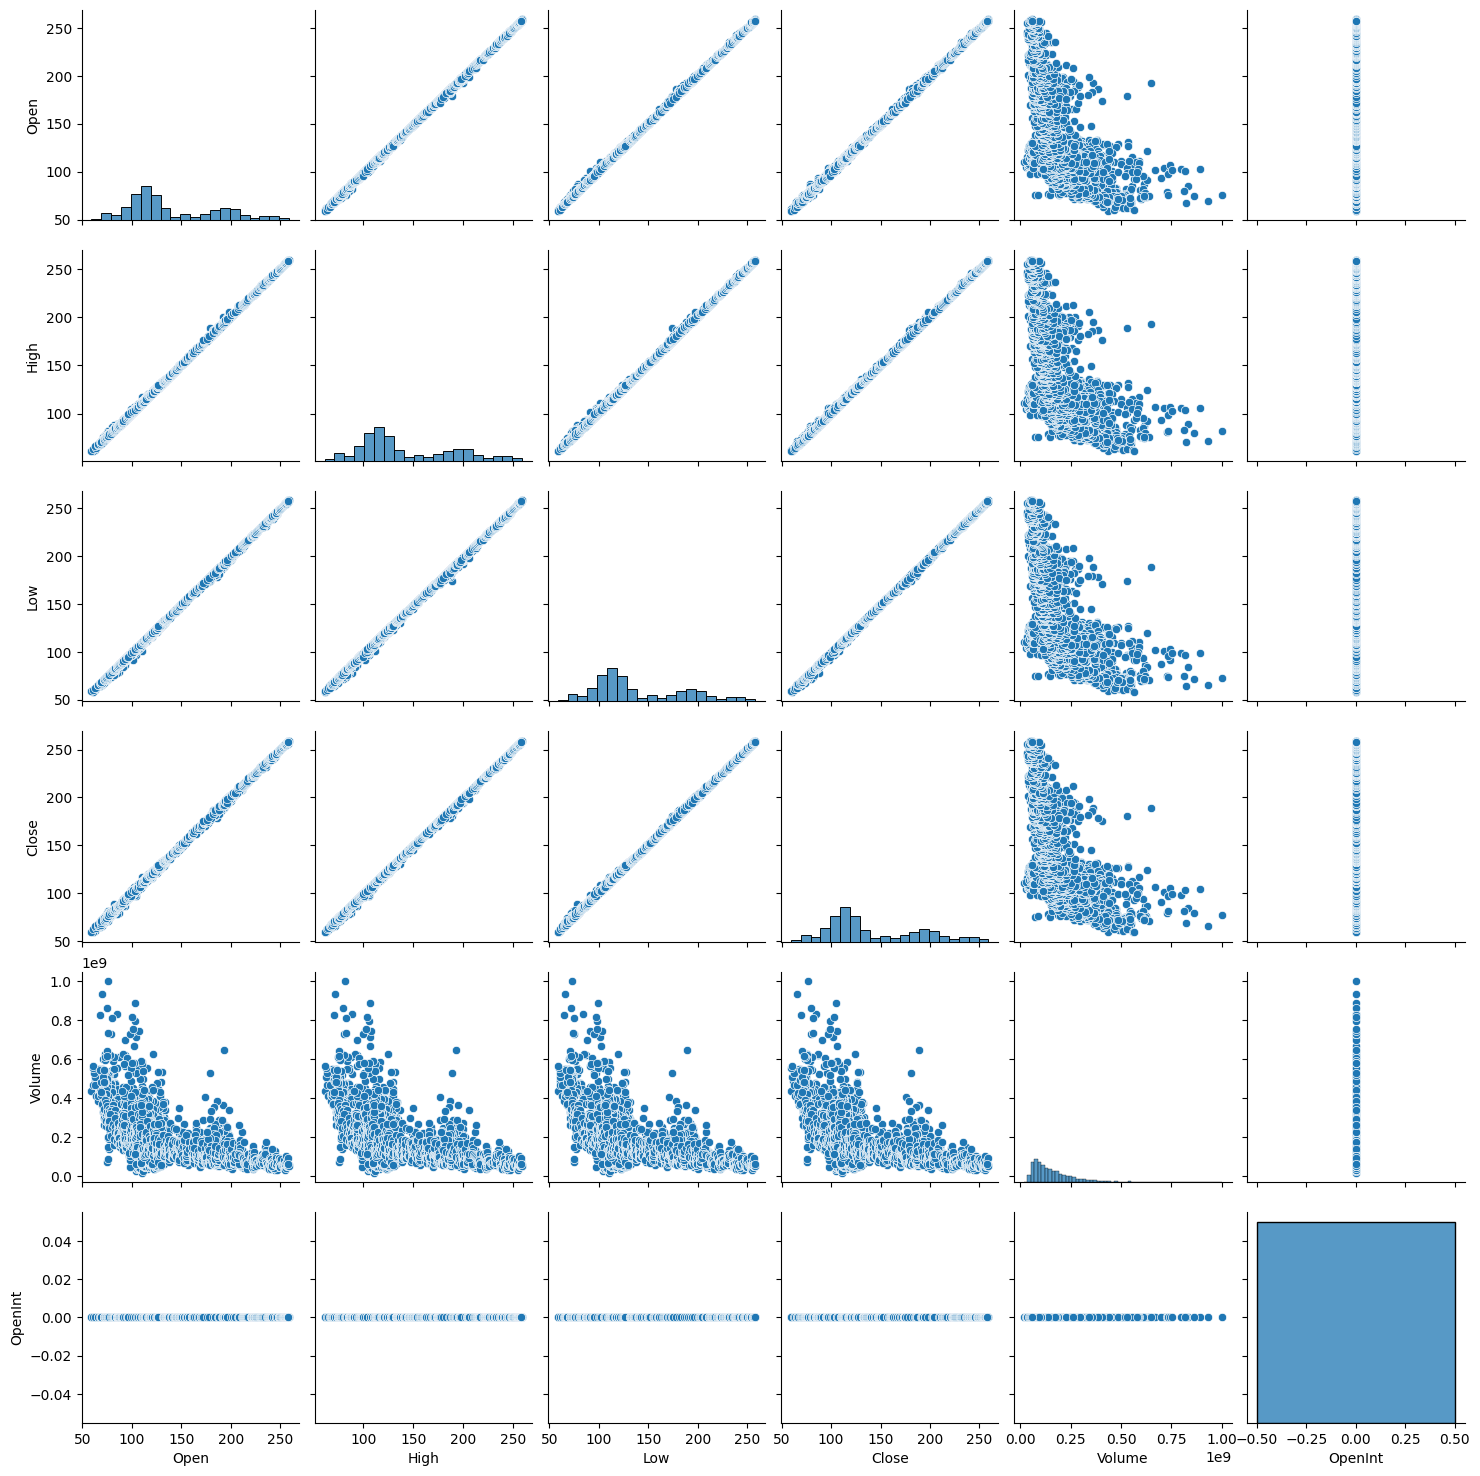

In [5]:
# Attribute pairplot
sns.pairplot(spy)

In [6]:
# general preprocessing function for stocks
def preprocess_data(ticker, timestep, ratio, date=None):
    # read in dataset for the ticker
    data = pd.read_csv(path + 'Stocks\\' + ticker + '.us.txt')
    # convert date to datetime 
    data['Date'] = pd.to_datetime(data['Date'])
    
    # crop dataset by certain date if applied
    if date:
        start_date = data['Date'] > date
        data = data[start_date]
    
    # use'Open' column only
    data_open = data.iloc[:,1:2].values
    
    # split data into training and testing data 
    split = int(len(data_open)*ratio)
    training_data = data_open[:split]
    testing_data = data_open[split:]
    
    # scale training data 
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_training_data = scaler.fit_transform(training_data)
    
    # create X_train and y_train
    X_train = []
    y_train = []
    for i in range(timestep, split):
        X_train.append(scaled_training_data[i-timestep:i, 0])
        y_train.append(scaled_training_data[i, 0])

    # convert X_train and y_train to proper shape for input to LSTM
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    return X_train, y_train, testing_data, data_open

In [13]:
# general testing function for model
def test_data(testing_data, timestep):
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_testing_data = scaler.fit_transform(testing_data)
    
    testing_data = testing_data.reshape(-1,1)
    testing_data = scaler.transform(testing_data)
    
    X_test = []
    for i in range(timestep, len(testing_data)):
        X_test.append(testing_data[i-timestep:i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    actual_stock_price = scaler.inverse_transform(testing_data)
    
    return predicted_stock_price, actual_stock_price

### AAPL (Apple)

In [8]:
timestep = 80
X_train, y_train, testing_data, aapl_open = preprocess_data('aapl', timestep, .8, date='2000-1-1')
print(X_train.shape)

(3514, 80, 1)


In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
55/55 [==============================] - 14s 143ms/step - loss: 0.0149
Epoch 2/50
55/55 [==============================] - 7s 126ms/step - loss: 0.0023
Epoch 3/50
55/55 [==============================] - 7s 124ms/step - loss: 0.0022
Epoch 4/50
55/55 [==============================] - 7s 122ms/step - loss: 0.0025
Epoch 5/50
55/55 [==============================] - 8s 139ms/step - loss: 0.0017
Epoch 6/50
55/55 [==============================] - 8s 152ms/step - loss: 0.0017
Epoch 7/50
55/55 [==============================] - 8s 147ms/step - loss: 0.0015
Epoch 8/50
55/55 [==============================] - 8s 141ms/step - loss: 0.0015
Epoch 9/50
55/55 [==============================] - 7s 132ms/step - loss: 0.0016
Epoch 10/50
55/55 [==============================] - 7s 130ms/step - loss: 0.0014
Epoch 11/50
55/55 [==============================] - 7s 131ms/step - loss: 0.0014
Epoch 12/50
55/55 [==============================] - 7s 130ms/step - loss: 0.0014
Epoch 13/50
55/55 [=====

In [10]:
model.save('aapl_model.h5')

In [14]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

26/26 [==============================] - 1s 30ms/step


In [16]:
# MSE of training
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.00036147344508208334


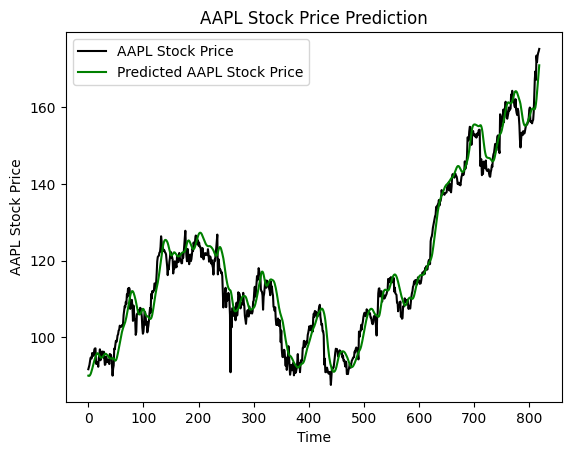

In [15]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

### NVDA (Nvidia)


In [ ]:
timestep = 60
X_train, y_train, testing_data, nvda_open = preprocess_data('nvda', timestep, .8, date='2000-1-1')
print(X_train.shape)

(3384, 60, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
53/53 [==============================] - 15s 126ms/step - loss: 0.0118
Epoch 2/50
53/53 [==============================] - 7s 126ms/step - loss: 0.0035
Epoch 3/50
53/53 [==============================] - 7s 127ms/step - loss: 0.0033
Epoch 4/50
53/53 [==============================] - 7s 127ms/step - loss: 0.0026
Epoch 5/50
53/53 [==============================] - 7s 128ms/step - loss: 0.0027
Epoch 6/50
53/53 [==============================] - 7s 126ms/step - loss: 0.0026
Epoch 7/50
53/53 [==============================] - 7s 126ms/step - loss: 0.0022
Epoch 8/50
53/53 [==============================] - 7s 128ms/step - loss: 0.0020
Epoch 9/50
53/53 [==============================] - 7s 127ms/step - loss: 0.0019
Epoch 10/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0018
Epoch 11/50
53/53 [==============================] - 7s 127ms/step - loss: 0.0018
Epoch 12/50
53/53 [==============================] - 7s 126ms/step - loss: 0.0017
Epoch 13/50
53/53 [=====

In [ ]:
model.save('nvda_model.h5')

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.0003205019165761769


In [ ]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

26/26 [==============================] - 2s 27ms/step


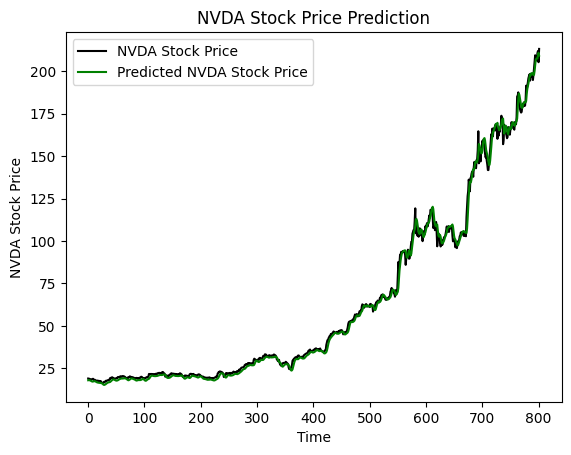

In [ ]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'NVDA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

### MSFT (Microsoft)

In [ ]:
timestep = 60
X_train, y_train, testing_data, msft_open = preprocess_data('msft', timestep, 0.8, date='2000-1-1')

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
53/53 [==============================] - 14s 127ms/step - loss: 0.0234
Epoch 2/50
53/53 [==============================] - 7s 124ms/step - loss: 0.0041
Epoch 3/50
53/53 [==============================] - 7s 125ms/step - loss: 0.0038
Epoch 4/50
53/53 [==============================] - 7s 126ms/step - loss: 0.0033
Epoch 5/50
53/53 [==============================] - 7s 131ms/step - loss: 0.0030
Epoch 6/50
15/53 [=======>......................] - ETA: 5s - loss: 0.0032

KeyboardInterrupt: 

In [ ]:
model.save('msft_model.h5')

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.00040904845809563994


In [ ]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

26/26 [==============================] - 2s 22ms/step


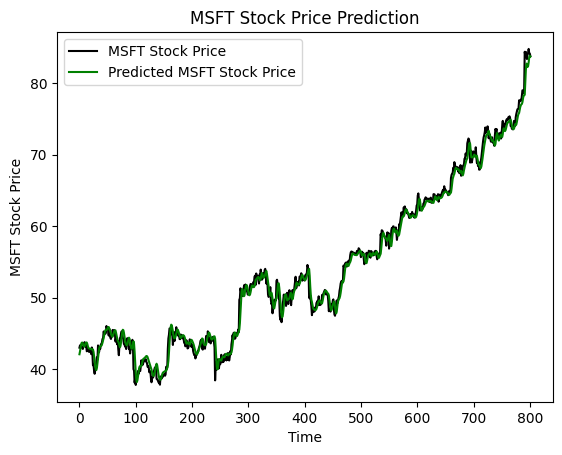

In [ ]:
# Plotting
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

### GOOGL (Google)

In [ ]:
timestep = 50
X_train, y_train, testing_data, googl_open = preprocess_data('googl', timestep, .85)

print(X_train.shape)

(2783, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
44/44 [==============================] - 8s 79ms/step - loss: 0.0202
Epoch 2/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0027
Epoch 3/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0025
Epoch 4/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0025
Epoch 5/100
44/44 [==============================] - 4s 80ms/step - loss: 0.0023
Epoch 6/100
44/44 [==============================] - 4s 80ms/step - loss: 0.0023
Epoch 7/100
44/44 [==============================] - 4s 79ms/step - loss: 0.0026
Epoch 8/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0025
Epoch 9/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0022
Epoch 10/100
44/44 [==============================] - 4s 80ms/step - loss: 0.0019
Epoch 11/100
44/44 [==============================] - 4s 80ms/step - loss: 0.0018
Epoch 12/100
44/44 [==============================] - 4s 80ms/step - loss: 0.0018
Epoch 13/100
44/44 [=====

44/44 [==============================] - 4s 81ms/step - loss: 5.7215e-04
Epoch 99/100
44/44 [==============================] - 4s 81ms/step - loss: 6.0043e-04
Epoch 100/100
44/44 [==============================] - 4s 82ms/step - loss: 5.3631e-04


In [ ]:
model.save('googl_model.h5')

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.0002533208462409675


In [ ]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

15/15 [==============================] - 1s 19ms/step


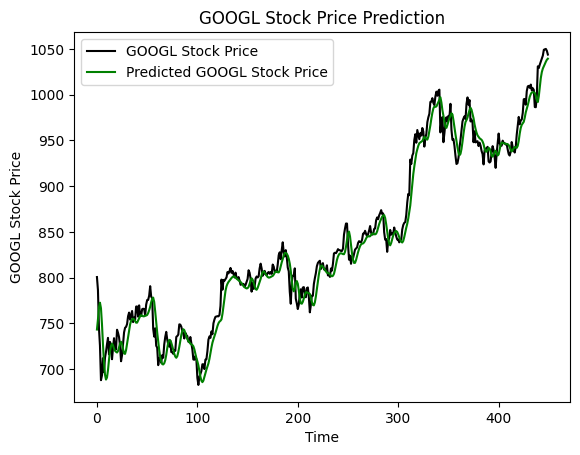

In [ ]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'GOOGL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted GOOGL Stock Price')
plt.title('GOOGL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGL Stock Price')
plt.legend()
plt.show()

### AMZN (Amazon)

In [ ]:
timestep = 50
X_train, y_train, testing_data, amzn_open = preprocess_data('amzn', timestep, .8, date='2000-1-1')
print(X_train.shape)

(3392, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
53/53 [==============================] - 9s 78ms/step - loss: 0.0104
Epoch 2/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0019
Epoch 3/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0020
Epoch 4/50
53/53 [==============================] - 4s 72ms/step - loss: 0.0016
Epoch 5/50
53/53 [==============================] - 4s 75ms/step - loss: 0.0015
Epoch 6/50
53/53 [==============================] - 4s 79ms/step - loss: 0.0016
Epoch 7/50
53/53 [==============================] - 4s 72ms/step - loss: 0.0014
Epoch 8/50
53/53 [==============================] - 4s 76ms/step - loss: 0.0016
Epoch 9/50
53/53 [==============================] - 4s 75ms/step - loss: 0.0014
Epoch 10/50
53/53 [==============================] - 4s 77ms/step - loss: 0.0013
Epoch 11/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0011
Epoch 12/50
53/53 [==============================] - 4s 75ms/step - loss: 0.0014
Epoch 13/50
53/53 [==================

In [ ]:
model.save('amzn_model.h5')

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

In [ ]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

26/26 [==============================] - 2s 20ms/step


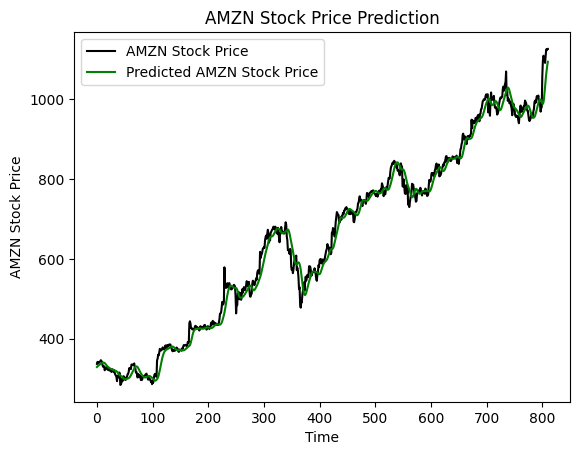

In [ ]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'AMZN Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()

## Generalized Model

In [ ]:
train_stocks = ['aapl', 'msft', 'amzn', 'nvda', 'googl']
test_stocks = ['ge', 'ibm', 'mo', 'hpq', 'ko']

In [ ]:
def preprocess_data(name, timestep = 50, date = None):
    scaler = MinMaxScaler()

    data = pd.read_csv(f'stocks\\{name}.us.txt')
    data['Date'] = pd.to_datetime(data['Date'])

    if date:
        start_date = data['Date'] >= date
        data = data[start_date]

    data = data.iloc[:,[1,4]].values
    data = data.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data)

    X_train = []
    y_train = []
    for i in range(timestep, len(data)):
        X_train.append(scaled_data[i - timestep:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, y_train

In [ ]:
def train_data(names, timestep = 50, date = None, epochs = 50, batch_size = 32, dropout = 0.2, units = 50, optimizer = 'adam', loss = 'mean_squared_error'):
    model = Sequential()

    model.add(LSTM(units=units, return_sequences=True, input_shape=(timestep, 1)))
    model.add(Dropout(dropout))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=units))
    model.add(Dropout(dropout))

    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss=loss)

    for name in names:
        X_train, y_train = preprocess_data(name, timestep = timestep, date = date)
        model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    return model

In [ ]:
def predict_data(model, names, timestep = 50, date = None):
    for name in names:
        scaler = MinMaxScaler()

        # data = pd.read_csv(f'stocks\\{name}.us.txt')
        data = pd.read_csv(f'us_etf_stocks_dataset\\stocks\\{name.lower()}.us.txt')

        if date:
            start_date = data['Date'] >= date
            data = data[start_date]

        data = data.iloc[:,[1,4]].values
        data = data.reshape(-1, 1)
        scaled_data = scaler.fit_transform(data)

        X_test = []
        for i in range(timestep, len(scaled_data)):
            X_test.append(scaled_data[i - timestep:i, 0])
        
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        prediction = model.predict(X_test)
        prediction = scaler.inverse_transform(prediction)

        print(f'MSE: {mean_squared_error(data[timestep:], prediction)}')
        print(f'R2: {r2_score(data[timestep:], prediction)}')

        name = name.upper()
        plt.plot(data[timestep:], color = 'black', label = f'Actual {name} Stock Price')
        plt.plot(prediction, color = 'green', label = f'Predicted {name} Stock Price')
        plt.title(f'{name} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

In [ ]:
model = train_data(train_stocks, timestep=50, date = '2000-01-01', epochs = 10, batch_size = 64)

In [ ]:
model.save('generalized_model.h5')

In [ ]:
predict_data(model, ['wmt', 'tsla', 'bABA', 'etsy', 'lc', 'c'], date = '2000-01-01')